In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

In [4]:
env = gym.make('CartPole-v1')
env.seed(1); torch.manual_seed(1);

task2
CartPoleEnv - Version 0.2.0, Noise case: 1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
#Hyperparameters
learning_rate = 0.01
gamma = 0.99

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128,self.action_space, bias=False)
        
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = (torch.tensor(0))        
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []

    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [5]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [6]:
def select_action(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(Variable(state))
    c = Categorical(state)
    action = c.sample()
    # Add log probability of our chosen action to our history
    if policy.policy_history.dim() != 0:
        policy.policy_history = torch.cat((policy.policy_history, c.log_prob(action).view(1)),0)
    else:
        policy.policy_history = (c.log_prob(action)).view(1)
    return action

In [7]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss)
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []

In [8]:
def main(episodes):
    running_reward = 10
    max_ = 480
    for episode in range(episodes):
        state = env.reset() # Reset environment and record the starting state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(int(action.data))

            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)

        update_policy()

        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))
        if(running_reward > max_) :
            max_ = running_reward
            torch.save(policy,"pg_task3.pkl")
        
        if running_reward > 499:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
            break


In [9]:
episodes = 10000
main(episodes)

Episode 0	Last length:    12	Average length: 10.02
Episode 50	Last length:    24	Average length: 14.14
Episode 100	Last length:    91	Average length: 20.14
Episode 150	Last length:    48	Average length: 23.36
Episode 200	Last length:    23	Average length: 30.42
Episode 250	Last length:    30	Average length: 41.42
Episode 300	Last length:    62	Average length: 47.69
Episode 350	Last length:    34	Average length: 45.97
Episode 400	Last length:    67	Average length: 44.03
Episode 450	Last length:    31	Average length: 46.84
Episode 500	Last length:    21	Average length: 42.66
Episode 550	Last length:    26	Average length: 34.32
Episode 600	Last length:    30	Average length: 30.09
Episode 650	Last length:    12	Average length: 25.91
Episode 700	Last length:    17	Average length: 28.63
Episode 750	Last length:    17	Average length: 27.01
Episode 800	Last length:    45	Average length: 28.14
Episode 850	Last length:    28	Average length: 30.05
Episode 900	Last length:    49	Average length: 32

/Users/uj007/anaconda3/envs/mlproject/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode 5250	Last length:   499	Average length: 485.26
Episode 5300	Last length:   499	Average length: 490.69
Episode 5350	Last length:   499	Average length: 493.90
Episode 5400	Last length:   499	Average length: 495.91
Episode 5450	Last length:   499	Average length: 497.13
Episode 5500	Last length:   499	Average length: 497.87
Episode 5550	Last length:   499	Average length: 498.32
Episode 5600	Last length:   499	Average length: 498.59
Episode 5650	Last length:   499	Average length: 498.75
Episode 5700	Last length:   499	Average length: 498.85
Episode 5750	Last length:   499	Average length: 498.91
Episode 5800	Last length:   499	Average length: 498.94
Episode 5850	Last length:   499	Average length: 498.97
Episode 5900	Last length:   499	Average length: 497.12


KeyboardInterrupt: 

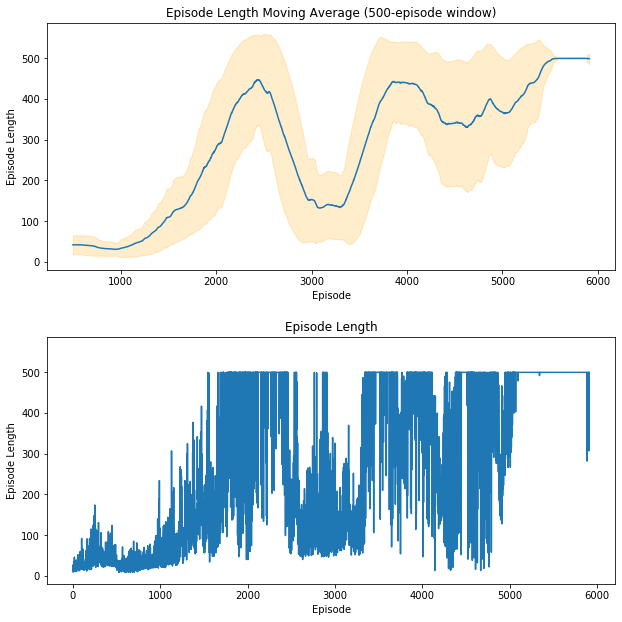

In [10]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')


In [12]:
test_episodes = 100
test_max_steps = 500
avg = 0 
policy = torch.load("pg_task3.pkl")
policy.eval()
for episode in range(1, test_episodes):
    t = 0
    rew = 0 
    env.reset()
    while t < test_max_steps: 
        
        if(t == 0) :
            action = 0 
        else :
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = policy(Variable(state))
            action = state.max(0)[1]
            
        state, reward, done , _ = env.step(int(action))
        rew += reward
        t += 1
        if(done) :
            break 
    avg += rew
print(avg/test_episodes)
env.close()

491.08
